In [1]:
import numpy as np

In [13]:
class nn():
    def __init__(self, 
                 hidden_nodes_list = [3],
                 initialWmultiplier = 0.01,
                 rate = 0.1,
                 epsilon = 0.000001,
                 max_iter = 1000,
                 hidden_act_fun = "relu", 
                 final_act_fun = "sigmoid", 
                 loss_function = "log_loss", 
                 verbose=True, 
                 test_mode=False):
        self.funName_list = np.append(np.repeat(hidden_act_fun, 
                                                len(hidden_nodes_list)), 
                                      final_act_fun)
        self.loss_function_name = loss_function
        
        self.nodes_list = hidden_nodes_list.copy()
        self.nodes_list.append(1)
        self.nlayers = len(self.nodes_list)
        self.layerIDs = list(range(1, self.nlayers + 1))
        self.initialWmultiplier = initialWmultiplier
        self.rate = rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.__verbose = verbose
        self.__test_mode = test_mode
    
    def __relu(self, z, alpha=1.0):
        return np.maximum(alpha * z, 0)    
    
    def __sigmoid(self, z):
        return 1 / (np.exp(-z) + 1)
    
    def __leakRelu(self, z, alpha=0.01):
        return np.maximum(z, alpha*z)
    
    # 根据激活函数名得到相应的计算公式
    def getActivationFun(self, name):
        name = name.lower()
        if name == "sigmoid":
            return self.__sigmoid
        if name == "relu":
            return self.__relu
        if name == "leaky relu":
            return self.__leakRelu
        
    def getLossFun(self, name):
        name = name.lower()
        if name == "log_loss":
            return lambda y_true, y_pred: np.mean(-(y_true * np.log(y_pred).T + (1 - y_true) * np.log(1 - y_pred).T))
        if name == "mse":
            return lambda y_true, y_pred: np.mean(np.square(y_true - y_pred))
    def getDerivateFun(self, name):
        name = name.lower()
        if name == "log_loss":
            return lambda A: (np.multiply(1 - self.y, 1 / (1 - A)) - np.multiply(self.y, 1 / A)) / A.shape[1]
        if name == "mse":
            return lambda A: (A - self.y) / A.shape[1]
        if name == "sigmoid":
            return lambda Z: np.multiply(self.__sigmoid(Z), 1 - self.__sigmoid(Z))
        if name == "relu":
            def f(x, alpha=1.0):
                z = x.copy()
                z[z >= 0] = alpha
                z[z < 0] = 0
                return z
            return  f
        if name == "leaky relu":
            def g(x, alpha=0.01):
                z = x.copy()
                z[z >= 0] = 1.0
                z[z < 0] = alpha
                return z
            return g

    # 生成初始参数矩阵
    # W_dic: 层号 -> 该层 W 矩阵
    # b_dic: 层号 -> 该层 b 向量
    # Z_dic: 层号 -> 该层的总输入 Z 矩阵
    def initializePars(self, total_nodes_list):
        self.W_dic = {}
        self.b_dic = {}
        self.Z_dic = {}
        self.A_dic = {}
        self.A_dic[0] = self.X
        for k in self.layerIDs:
            ## (1) randomly for each w
            self.W_dic[k] = np.mat(
                np.abs(np.random.randn(total_nodes_list[k], total_nodes_list[k - 1]))
            ) * self.initialWmultiplier
            
#             # (2-1) same by node but diff by features and same on last layer
#             if k != self.nlayers:
#                 unit = np.random.randn(1, total_nodes_list[k-1])
#                 self.W_dic[k] = np.mat(np.repeat(unit, axis=0, repeats=total_nodes_list[k]))
#             else:
#                 self.W_dic[k] = np.mat(np.zeros((total_nodes_list[k], total_nodes_list[k-1])))
#                 self.W_dic[k][True] = np.random.rand()
            
            
#             # (2-2) same by node but diff by features so does last layer
#             unit = np.random.randn(1, total_nodes_list[k-1])
#             self.W_dic[k] = np.mat(np.repeat(unit, axis=0, repeats=total_nodes_list[k]))
            
#             # (3) same by all 
#             self.W_dic[k] = np.mat(np.zeros((total_nodes_list[k], total_nodes_list[k-1])))
#             self.W_dic[k][True] = np.random.rand()
            
            self.b_dic[k] = np.mat(np.zeros((total_nodes_list[k], 1)))
            #self.b_dic[k][True] = np.random.rand()
            #self.b_dic[k] = np.mat(np.random.randn(total_nodes_list[k], 1))
            tmp = np.mat(np.zeros((total_nodes_list[k], self.nSize)))
            self.Z_dic[k] = tmp
            self.A_dic[k] = tmp      
        return self
    def  __print_param(self):
        for layer in self.layerIDs:
            print("layer:", layer)
            print(self.W_dic[layer])
            print(self.b_dic[layer])
            print("\n")
            
    
    def forwardCal(self, X):
        A = X.copy()
        for k in self.layerIDs:
            W = self.W_dic[k]
            b = self.b_dic[k]
            Z = W * A + b
            self.Z_dic[k] = Z
            A = self.fun_dic[k](Z)
            self.A_dic[k] = A
        return A
    
    def backwardCal(self):
        dA = self.loss_derivate(self.A_dic[self.nlayers])
        
        for k in np.flip(self.layerIDs, axis=0):
            act_derivate_fun = self.derivate_dic[k]
            dZ = np.multiply(dA, act_derivate_fun(self.Z_dic[k]))
            dW = dZ * (self.A_dic[k-1].T)
            db = np.sum(dZ, axis=1)
            dA = (self.W_dic[k].T) * dZ
            
            self.W_dic[k] += -self.rate * dW
            self.b_dic[k] += -self.rate * db
        
    def fit(self, X, y):
        assert y.shape[1] == X.shape[1], "shape unmatched between X and y"
        self.X = np.mat(X)
        self.y = np.mat(y)
        self.loss_fun = self.getLossFun(self.loss_function_name)
        self.nFeatures, self.nSize = self.X.shape
        self.total_nodes_list = np.r_[self.nFeatures, self.nodes_list]
        self.initializePars(self.total_nodes_list)
        self.fun_dic = dict(zip(self.layerIDs, map(self.getActivationFun, self.funName_list)))
        self.loss_derivate = self.getDerivateFun(self.loss_function_name)
        self.derivate_dic = dict(zip(self.layerIDs, map(self.getDerivateFun, self.funName_list)))
        
        if not self.__test_mode:   
            i = 0
            self.log = []
            Jold = np.inf
            while i <= self.max_iter:
                if i % 50 == 0:
                    print("iter-", i)
                    self.__print_param()
                self.yHat = self.forwardCal(self.X)
                J = self.loss_fun(self.y, self.yHat)
                self.log.append(J)
                if self.__verbose:
                    print("loss of Iter %d is: %.4f" % (i, J))
                if Jold - J >= self.epsilon:
                    self.backwardCal()
                else:
                    break
                Jold = J
                
                i += 1
            
    def predict_proba(self, X):
        assert X.shape[0] == self.nFeatures
        y_score = self.forwardCal(X).reshape(-1, 1)
        return np.c_[1-y_score, y_score]
    
    def predict(self, X):
        y_score = self.predict_proba(X)
        y = (y_score >= 0.5).reshape(-1, 1)
        return list(map(int, y))

In [14]:
n1 = nn(rate=0.1, 
        max_iter=100, 
        epsilon=0,
        hidden_act_fun="leaky relu", 
        final_act_fun="sigmoid",
        hidden_nodes_list=[3,4,5,2], 
        verbose=False, 
        test_mode=False)

In [4]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
data = load_iris()
rawX = data.data

scaler = StandardScaler(with_mean=True, with_std=True)
rawX = scaler.fit_transform(rawX)
rawy = data.target
mask = rawy < 2
X = rawX[mask]
y = rawy[mask].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
n1.fit(X_train.T, y_train.T)

iter- 0
layer: 1
[[ 0.27950103  0.27950103  0.27950103  0.27950103]
 [ 0.27950103  0.27950103  0.27950103  0.27950103]
 [ 0.27950103  0.27950103  0.27950103  0.27950103]]
[[ 0.98324885]
 [-1.92989966]
 [-0.1612314 ]]


layer: 2
[[ 0.72463301  0.72463301  0.72463301]
 [ 0.72463301  0.72463301  0.72463301]
 [ 0.72463301  0.72463301  0.72463301]
 [ 0.72463301  0.72463301  0.72463301]]
[[ 1.62968873]
 [-1.33659394]
 [ 2.03745388]
 [-0.95137762]]


layer: 3
[[ 0.40931905  0.40931905  0.40931905  0.40931905]
 [ 0.40931905  0.40931905  0.40931905  0.40931905]
 [ 0.40931905  0.40931905  0.40931905  0.40931905]
 [ 0.40931905  0.40931905  0.40931905  0.40931905]
 [ 0.40931905  0.40931905  0.40931905  0.40931905]]
[[-0.71831869]
 [-0.28019535]
 [ 1.88742268]
 [-0.51518943]
 [-0.67971359]]


layer: 4
[[ 0.00939116  0.00939116  0.00939116  0.00939116  0.00939116]
 [ 0.00939116  0.00939116  0.00939116  0.00939116  0.00939116]]
[[-0.26794599]
 [-1.68965235]]


layer: 5
[[ 0.4976289  0.4976289]]
[[-0.

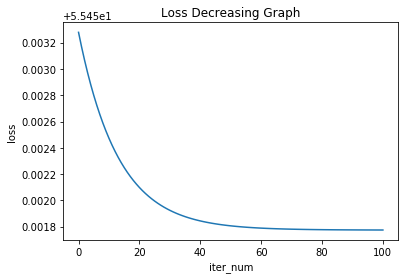

In [9]:
plt.plot(n1.log)
plt.ylabel("loss")
plt.xlabel("iter_num")
plt.title("Loss Decreasing Graph")
plt.show()

In [10]:
y_score = n1.predict_proba(X_test.T)

In [11]:
fpr, tpr, thresh = roc_curve(y_true=y_test, y_score=y_score[:, 1].reshape(-1, 1), pos_label=1)
print("auc:", auc(fpr, tpr))

auc: 0.81


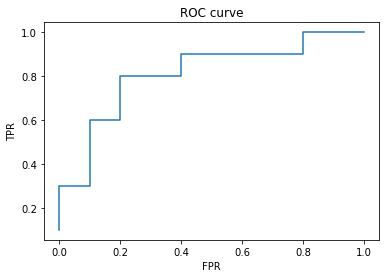

In [12]:
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()